## Sentiment Analysis of FIFA 2022 Tweets
Welcome to this project notebook! In this project, I perform sentiment analysis on tweets related to FIFA 2022. This analysis involves categorizing tweets as positive, negative, or neutral, providing insights into the public's perception and sentiment regarding one of the world's most anticipated sporting events.

### Context
The FIFA 2022 World Cup captured the attention of millions around the globe, and social media platforms like Twitter were flooded with discussions and reactions to the event. This project aims to perform sentiment analysis on a dataset of 22,000 tweets collected from the first day of FIFA 2022. By understanding the public's sentiment toward the event, we can gain insights into the prevailing opinions and emotions associated with one of the most popular sporting events in the world.

### Project Outline
1. Text Cleaning & Preprocessing: We utilize the spaCy library for efficient text cleaning and preprocessing to ensure that the data is in a usable form for analysis.
2. Feature Extraction: GloVe embeddings are employed for robust feature extraction, allowing us to represent the tweet content effectively and capture its semantic meaning.
3. Exploratory Data Analysis: Word frequency analysis is conducted as part of the exploratory data analysis (EDA) phase to identify important terms and patterns within the tweets.
4. Machine Learning Models: Several machine learning models are built and evaluated, including XGBoost, Random Forest Classifier, Multinomial Logistic Regression, and K-Nearest Neighbors (KNN) classification.
5. Hyperparameter Tuning: Grid Search is used to optimize the hyperparameters for the XGBoost model, which achieves the highest performance score among the models tested.

### Objectives
1. Sentiment Classification: Accurately categorize tweets as positive, negative, or neutral.
2. Model Performance: Build and compare multiple machine learning models to determine the most effective approach.

Lets Dive in

In [1]:
# loading dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import spacy
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# loading tweets dataset
tweets =pd.read_csv(r'C:\Users\Hp\Downloads\fifa_world_cup_2022_tweets.csv')
tweets.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


## EDA

In [3]:
tweets.shape

(22524, 6)

In [4]:
# checking for missing values
tweets.isnull().sum()

Unnamed: 0         0
Date Created       0
Number of Likes    0
Source of Tweet    0
Tweet              0
Sentiment          0
dtype: int64

In [5]:
tweets.duplicated().any()

False

Text(0.5, 1.0, 'didtribution of Target Variable')

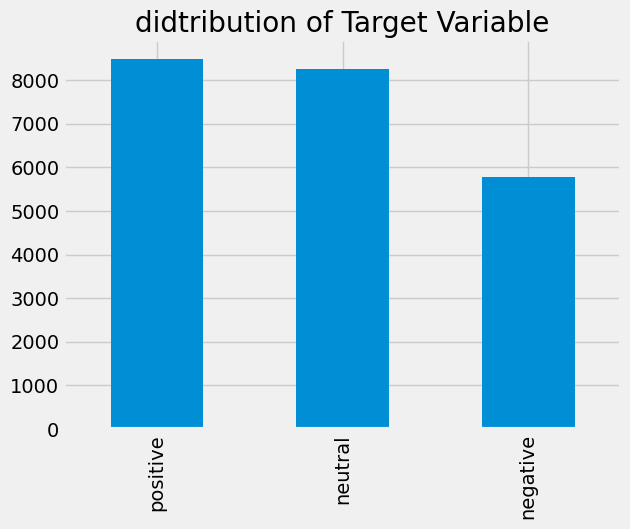

In [6]:
# Checking for distribution of Target Variable
tweets['Sentiment'].value_counts().plot.bar()
plt.title('didtribution of Target Variable')

In [7]:
# Label encoding
label_mapping={
    'negative':0,
    'neutral' :1,
    'positive' : 2
}

tweets['Sentiment']=tweets['Sentiment'].map(label_mapping)
tweets.head(10)

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,1
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,2
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,2
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,2
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",0
5,5,2022-11-20 23:57:32+00:00,0,Twitter for Android,"And like, will the mexican fans be able to scr...",0
6,6,2022-11-20 23:57:06+00:00,0,Twitter for Android,Look like a only me and the Jamaican football ...,1
7,7,2022-11-20 23:57:05+00:00,0,Twitter for Android,Really? Football on a Monday morning at 9 and ...,0
8,8,2022-11-20 23:56:10+00:00,1,Twitter for iPhone,"As the World Cup starts in Qatar, it’s Black A...",2
9,9,2022-11-20 23:56:08+00:00,0,Twitter for iPhone,#WorldCup2022 @ITVSport &amp; @LFSYSTEMMUSIC g...,2


<Axes: >

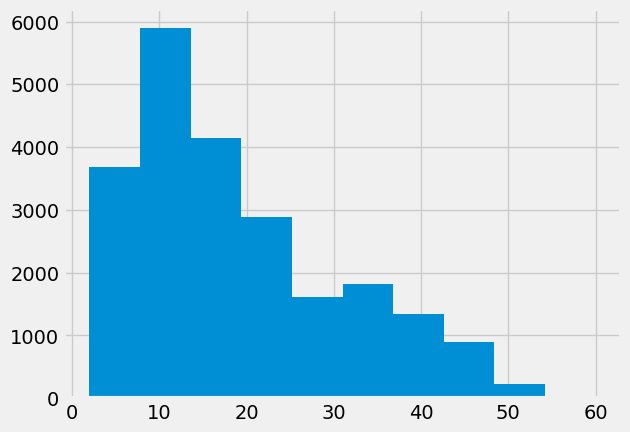

In [8]:
# tweet length analysis
tweets['length']=tweets['Tweet'].str.split().apply(len)
tweets['length'].hist()

### Handling class imbalance

In [9]:
neg_df=tweets.query("Sentiment==0")
pos_df=tweets.query("Sentiment==2")
nuet_df=tweets.query("Sentiment==1")
neg_df_resampled=neg_df.sample(pos_df.shape[0],replace=True)
neut_df_resampled=nuet_df.sample(pos_df.shape[0],replace=True)
tweets=pd.concat([neut_df_resampled,pos_df,neg_df_resampled])
print(tweets.shape)

(25467, 7)


Text(0.5, 1.0, 'didtribution of Target Variable')

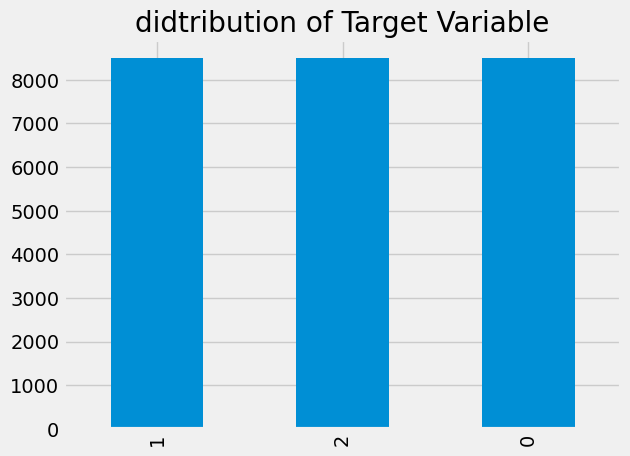

In [10]:
tweets['Sentiment'].value_counts().plot.bar()
plt.title('didtribution of Target Variable')

## Cleaning our tweets to remove hashtags,usernames and non alphabetical letters

In [11]:
from collections import Counter
import re
# load spacy language model for english
nlp=spacy.load('en_core_web_sm')

# create a function to tokenize the tweet
def preprocess(text):
    #text=re.sub(r'#\w+','',text)
    text = re.sub(r'(^|\s)@(\w+)', '', text)
    # remove links using regular expression
    text=re.sub(r'http[s]?://\S+','',text)
    # remove non word characters
    text=re.sub(r'[^a-zA-Z\s]','',text)
    # remove new line character
    text=re.sub(r'\s+',' ',text)
    # strip leading and trailing spaces
    text=text.strip()
    #create a spacy document
    doc=nlp(text)
    #tokenize and process the text
    tokens=[token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

In [12]:
tweets['preprocessed_tweet']=tweets['Tweet'].apply(preprocess)
tweets.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,length,preprocessed_tweet
18239,18239,2022-11-20 11:45:08+00:00,2,Twitter for Android,Finally all families are going to take a break...,1,21,finally family go break soap opera tele novell...
14386,14386,2022-11-20 15:11:05+00:00,3,Twitter for iPhone,The #FIFAWorldCup kicks off in less than an ho...,1,23,fifaworldcup kick hour check fm predict tourna...
17697,17697,2022-11-20 12:18:20+00:00,0,Planable,🏆 🏴󠁧󠁢󠁥󠁮󠁧󠁿 #England To Win The #WorldCup? 🤔 \n\...,1,42,england win worldcup good odd lions lift troph...
16892,16892,2022-11-20 13:33:21+00:00,11,SMMplanner,Qatar and Ecuador kick off the World Cup🏆 with...,1,30,qatar ecuador kick world cup openingday match ...
7128,7128,2022-11-20 16:13:34+00:00,2,Twitter for Android,Are you sure alcohol is banned in the stadium?...,1,21,sure alcohol ban stadium var duty extremely dr...


## word Frequency analysis

In [13]:
word_freq=tweets['preprocessed_tweet'].str.split().explode().value_counts().reset_index()
word_freq.columns=['Word','Frequency']
word_freq['Frequency']=word_freq.Frequency.astype(int)

word_freq

,Word,Frequency
0,worldcup,29166
1,qatar,9839
2,world,6723
3,cup,6044
4,fifaworldcup,4570
...,...,...
17280,letsbringithome,1
17281,rumoaohexa,1
17282,woahhhhhhh,1
17283,jugular,1


In [14]:
from wordcloud import WordCloud
word_frequencies=dict(zip(word_freq['Word'],word_freq['Frequency']))
wordcloud=WordCloud(width=800,height=400,background_color='white').generate_from_frequencies(word_frequencies)

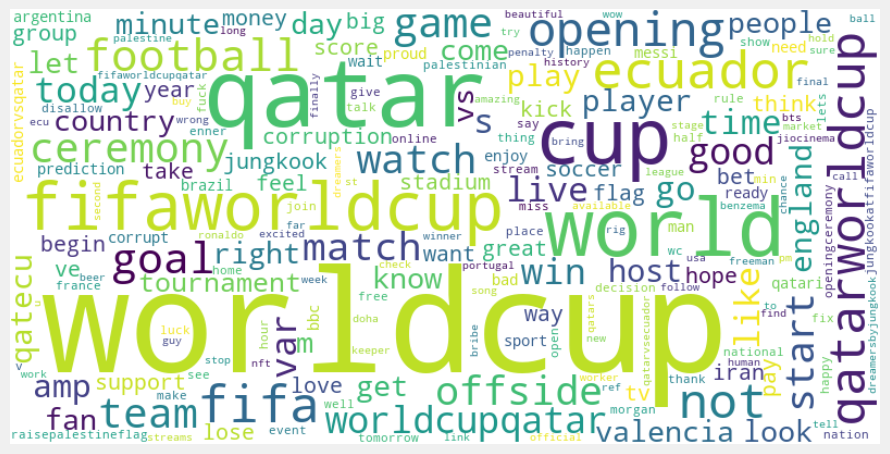

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
#split the data to training and testing 
X=tweets['preprocessed_tweet']
y=tweets['Sentiment']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=40)

## Word Embedding

In [17]:
# create an embedding index
import os
import numpy as np
glove_dir=r'C:\Users\Hp\Downloads\archive (97)'
embedding_index={}
with open(os.path.join(glove_dir,'glove.twitter.27B.200d.txt'),encoding='utf8') as f:
    try:
        for line in f:
            values=line.split()
            word=values[0]
            coefs=np.asarray(values[1:],dtype='float32')
            embedding_index[word]=coefs
    except ValueError:
        pass

## Tweets embeddings

In [18]:
def sentence_embeddings_avg(sentence):
    # split sentence to words
    words=sentence.split()
    embeddings=[embedding_index[word] for word in words if word in embedding_index]
    if embeddings:
        sentence_array=np.array(embeddings)
        sentence_vectors=np.mean(sentence_array,axis=0)
    else:
        sentence_vectors=np.zeros(200)
    return sentence_vectors

In [19]:
X_train_embeddings=np.array(X_train.apply(sentence_embeddings_avg))
X_test_embeddings=np.array(X_test.apply(sentence_embeddings_avg))

In [20]:
X_train_embeddings.shape

(20373,)

In [21]:
feature_matrix_xtrain=np.vstack(X_train_embeddings)
feature_matrix_xtest=np.vstack(X_test_embeddings)

## Building Model
### xgboost,RandomForestClassifier,LogisticRegression,KNeighborsClassifier

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [23]:
xgb_classifier=xgb.XGBClassifier(objective='multi:softmax',num_classes=3)
xgb_classifier.fit(feature_matrix_xtrain,y_train)
y_pred=xgb_classifier.predict(feature_matrix_xtest)

In [24]:
accuracy_score(y_pred,y_test)

0.8419709462112289

In [25]:
#random forest classifier model
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier()
rf_classifier.fit(feature_matrix_xtrain,y_train)
y_pred=rf_classifier.predict(feature_matrix_xtest)

In [26]:
accuracy_score(y_pred,y_test)

0.8309776207302709

In [27]:
# multinomial logistic regression
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=1000)

model.fit(feature_matrix_xtrain,y_train)
y_pred=model.predict(feature_matrix_xtest)

In [28]:
accuracy_score(y_pred,y_test)

0.7133882999607382

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(feature_matrix_xtrain,y_train)

y_pred=knn.predict(feature_matrix_xtest)

In [30]:
accuracy_score(y_pred,y_test)

0.709658421672556

Best model is xgb_classifier with accuracy_score of 84%.

## Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.style as styles
styles.use("fivethirtyeight")

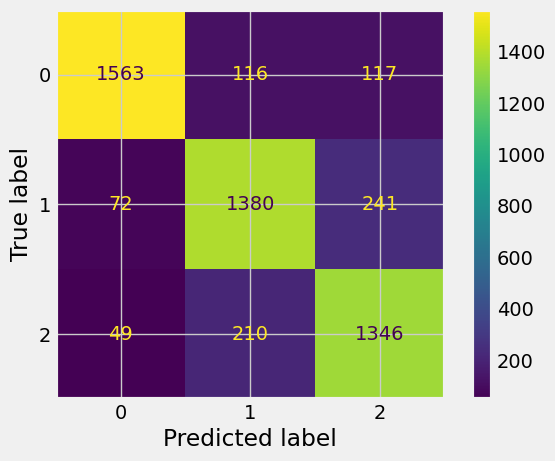

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

In [45]:
!jupyter nbconvert --to webpdf --allow-chromium-download FIFA_tweets_sentiment_analysis.ipynb

[NbConvertApp] Converting notebook FIFA_tweets_sentiment_analysis.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 626978 bytes to FIFA_tweets_sentiment_analysis.pdf
